In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psycopg2
import pickle

In [2]:
# Database connection parameters
db_params = {
    "host": "localhost",        # Replace with your PostgreSQL host
    "database": "bcb",      # Replace with your database name
    "user": "konstantinos",        # Replace with your username
    "password": "1234" # Replace with your password
}

# Establish a database connection
conn = psycopg2.connect(**db_params)

In [3]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

In [4]:
random_split_performance = {}
random_split_performance['codegrid'] = {'f1':97.8, 'p':99.6, 'r':96.1, 'a':None}
random_split_performance['codebert'] = {'f1':94.1, 'p':94.7, 'r':93.4, 'a':None}
random_split_performance['astnn']    = {'f1':93.8, 'p':99.8, 'r':88.4, 'a':None}

In [5]:
functionalities = pd.read_sql_query("SELECT * FROM functionalities", conn)

/var/folders/j9/k05ysrr550d9bhp1ns50p1hm0000gn/T/ipykernel_21553/1147858861.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  functionalities = pd.read_sql_query("SELECT * FROM functionalities", conn)


In [6]:
def draw_performance_line(d, metric, codegrid_non_gen_setting, model_name):
    
    fig, ax = plt.subplots(figsize=(13, 8))
    
    x = range(len(d))
    ax.plot(x, d[metric + '_b'], '-*', color=colors[1], label=model_name + ' + simple finetuning')
    ax.plot(x, d[metric+'_s']    , '-*', color=colors[2], label=model_name + ' + siamese finetuning')
    ax.plot([x[0], x[-1]], [codegrid_non_gen_setting, codegrid_non_gen_setting], '--', color='black', label='non-generalization setting') 

    ax.legend(loc='best')
    ax.set_xlabel('Functionality left out')
    ax.set_ylabel(metric + ' %')
    ax.set_title('one-vs-rest on BCB')
    ax.grid()
    ax.set_xticks(x, d['name'], rotation=90)

In [9]:
def draw_performance_scatter(d, metric, codegrid_non_gen_setting, model_name):
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(d[metric + '_b'], d[metric+'_s'], '*', color=colors[1], markersize=15)
    ax.set_xlabel(model_name + ' + simple finetuning')
    ax.set_ylabel(model_name + ' + siamese finetuning')
    ax.set_title(metric)
    ax.grid()
    ax.set_xlim([60, 101])
    ax.set_ylim([60, 101])

### 1-vs-rest

In [30]:

result_files = {
    'codebert_b': '/Users/konstantinos/local-desktop/Clones paper replication package/codebert/result-codebert-baseline-20240306-192546.pickle',
    'codebert_s': '/Users/konstantinos/local-desktop/Clones paper replication package/codebert/result-codebert-siamese-20240306-201416.pickle',
    'astnn_b': '/Users/konstantinos/local-desktop/Clones paper replication package/astnn/result-astnn-baseline-20240304-145604.pickle',
    'astnn_s': '/Users/konstantinos/local-desktop/Clones paper replication package/astnn/result-astnn-siam-20240304-145607.pickle',
    'codegrid_b':'/Users/konstantinos/local-desktop/Clones paper replication package/codegrid/result-codegrid-baseline-20240306-211644.pickle',
    'codegrid_s':'/Users/konstantinos/local-desktop/Clones paper replication package/codegrid/result-codegrid-siamese-20240306-212841-100.pickle'
}
result = {
    'codebert':{},
    'astnn':{},
    'codegrid':{}
}

for model_name in ['codebert', 'astnn', 'codegrid']:
    with open(result_files[model_name+"_s"], 'rb') as handle:
        result_s = pickle.load(handle)
    
    with open(result_files[model_name+"_b"], 'rb') as handle:
        result_b = pickle.load(handle)

    fcn_ids = result_b['fcn_id']
    f1_b = result_b['f1']
    p_b  = result_b['p']
    r_b  = result_b['r']
    a_b  = result_b['a']
    
    f1_s = result_s['f1']
    p_s  = result_s['p']
    r_s  = result_s['r']
    a_s  = result_s['a']
    
    d = pd.DataFrame({'functionality_id': fcn_ids, 'f1_b': f1_b, 'f1_s':f1_s, 'p_b':p_b, 'p_s':p_s, 'r_b':r_b, 'r_s':r_s, 'a_b':a_b, 'a_s':a_s})
    metrics = ['f1', 'p', 'r', 'a']
    
    models = ['b']
    for metric in metrics:
        for model in models:
            k = metric+"_"+model
            d[k] = d[k]*100
    
    models = ['s']
    for metric in metrics:
        for model in models:
            k = metric+"_"+model
            d[k] = d[k]*100
    
    d = pd.merge(d, functionalities, how="left", left_on="functionality_id", right_on="id")
    d = d.drop({'description', 'id', 'search_heuristic'}, axis=1)
    
    result[model_name] = d


# if model_name == 'astnn':
#     # ASTNN siamese
#     fname_results_s = '/Users/konstantinos/local-desktop/Clones paper replication package/astnn/result-astnn-siam-20240304-145607.pickle'
#     with open(fname_results_s, 'rb') as handle:
#         result_s = pickle.load(handle)
    
#     # ASTNN baseline
#     fname_results_b = '/Users/konstantinos/local-desktop/Clones paper replication package/astnn/result-astnn-baseline-20240304-145604.pickle'
#     with open(fname_results_b, 'rb') as handle:
#         result_b = pickle.load(handle)

# elif model_name == 'codegrid':
#     # CodeGrid siamese
#     fname_results_s = '/Users/konstantinos/local-desktop/Clones paper replication package/codegrid/result-codegrid-siamese-20240306-212841-100.pickle'
#     with open(fname_results_s, 'rb') as handle:
#         result_s = pickle.load(handle)
    
#     # CodeGrid baseline
#     fname_results_b = '/Users/konstantinos/local-desktop/Clones paper replication package/codegrid/result-codegrid-baseline-20240306-211644.pickle'
#     with open(fname_results_b, 'rb') as handle:
#         result_b = pickle.load(handle)
        
# elif model_name == 'codebert':
#     # CodeBERT siamese
#     fname_results_s = '/Users/konstantinos/local-desktop/Clones paper replication package/codebert/result-codebert-siamese-20240306-201416.pickle'
#     with open(fname_results_s, 'rb') as handle:
#         result_s = pickle.load(handle)
    
#     # CodeBERT baseline
#     fname_results_b = '/Users/konstantinos/local-desktop/Clones paper replication package/codebert/result-codebert-baseline-20240306-192546.pickle'
#     with open(fname_results_b, 'rb') as handle:
#         result_b = pickle.load(handle)

In [33]:
model_name = 'codebert'
metric = 'f1'
mean_b = result[model_name][metric + '_b'].mean()
med_b  = result[model_name][metric + '_b'].median()
mean_s = result[model_name][metric + '_s'].mean()
med_s  = result[model_name][metric + '_s'].median()
print(mean_b)
print(med_b)
print(mean_s)
print(med_s)

print("Mean diff: %0.2f\nMedian diff: %0.2f" % (mean_s - mean_b, med_s - med_b))

85.52286251213133
89.83957219251336
85.65826978168552
89.94708994708994
Mean diff: 0.14
Median diff: 0.11


### RQ2: Baseline@1vsRest vs Baseline@randomSplit

In [25]:
from scipy.stats import ranksums
from scipy.stats import wilcoxon

In [26]:
# Create a new series of differences from the constant value
differences = d[metric + '_b'] - random_split_performance[model_name][metric]

# Perform the Wilcoxon Signed-Rank Test
# Note: We use the differences from t, as the test compares against a median of 0
stat, p_value = wilcoxon(differences)

print(f'Wilcoxon Signed-Rank Test Statistic: {stat}, P-value: {p_value}')
if p_value < 0.01:
    print("--> Statistically important difference")

Wilcoxon Signed-Rank Test Statistic: 55.0, P-value: 0.010109186172485352


### RQ3: Baseline vs Siamese

In [27]:
# Perform the Wilcoxon Rank-Sum Test
stat, p_value = ranksums(d[metric + '_b'], d[metric + '_s'])

print(f'Wilcoxon Rank-Sum Test Statistic: {stat}, P-value: {p_value}')
if p_value < 0.01:
    print("--> Statistically important difference")

Wilcoxon Rank-Sum Test Statistic: -0.2965839374190784, P-value: 0.7667841754766687


---

### Merge all results to plot the boxplots

---

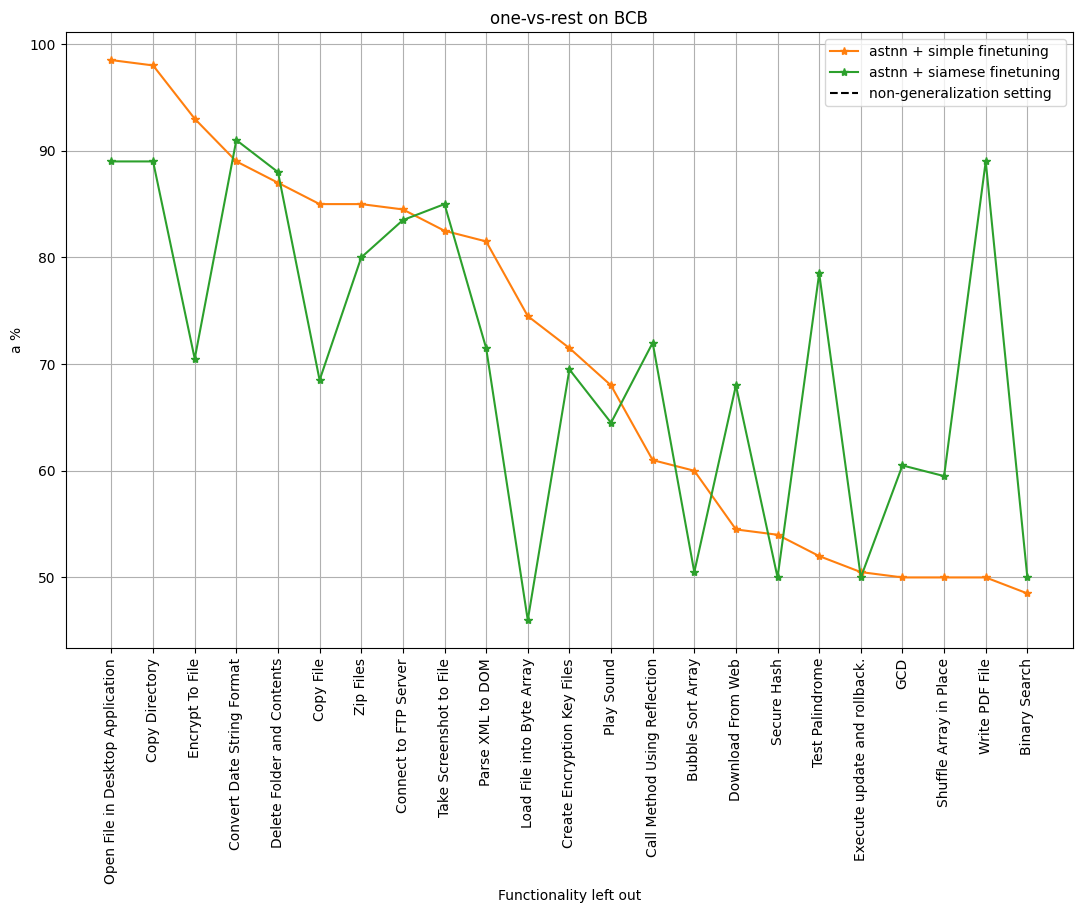

In [19]:
metric = 'a'

d_sort = d.sort_values(metric+'_b', ascending=False)
# d_sort = d.sort_values('test_size', ascending=False)
draw_performance_line(d_sort, metric, astnn_non_gen_setting[metric], model_name)

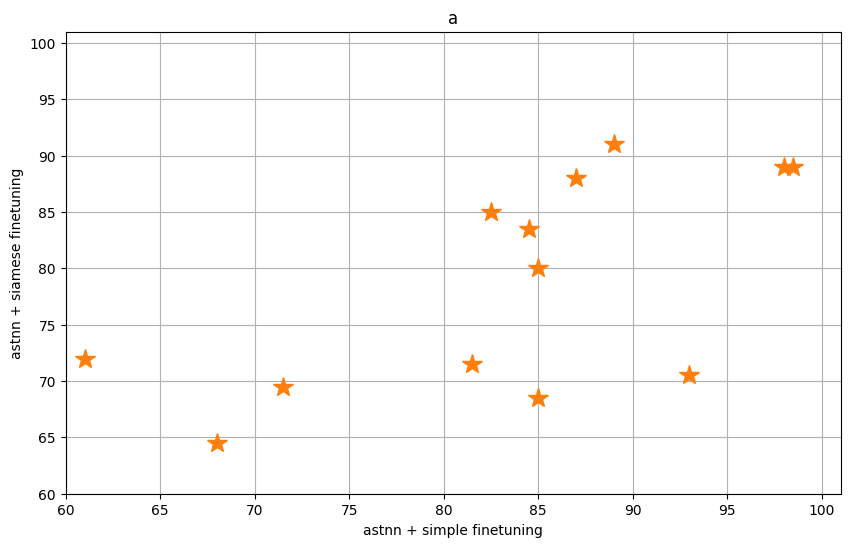

In [20]:
draw_performance_scatter(d, metric, astnn_non_gen_setting[metric], model_name)

In [22]:
colors

['#1f77b4', '#ff7f0e', '#2ca02c']

In [23]:
def draw_barplot(f1, acc, p, r, model, colors, non_gen_setting, title=''):
        
    # Bar width
    bar_width = 0.9
    
    # Create positions for the bars
    if len(f1) == 2:
        models = [model+' + simple finetuning', model+' +siamese finetuning']
    elif len(f1) == 3:
        models = [model+' simple funetuning from paper', model+' + simple finetuning', model+' +siamese finetuning']


    n_models = len(models)
    bar_positions_f1  = np.arange(n_models)
    bar_positions_p   = bar_positions_f1 + n_models + 1
    bar_positions_r   = bar_positions_p + n_models + 1
    bar_positions_acc = bar_positions_r + n_models + 1

    
    # Increase figure height
    fig, ax = plt.subplots(figsize=(13, 8))
    
    # Create a bar plot for F1 scores
    ax.bar(bar_positions_f1, f1, width=bar_width, color=colors, label='F1 Score')

    ax.bar(bar_positions_p, p, width=bar_width, color=colors, label='F1 Score')
    ax.bar(bar_positions_r, r, width=bar_width, color=colors, label='F1 Score')

    
    # Create a bar plot for accuracy scores
    ax.bar(bar_positions_acc, acc, width=bar_width, color=colors, label='Accuracy')



    ax.plot([bar_positions_f1[0], bar_positions_f1[-1]], [non_gen_setting['f1'], non_gen_setting['f1']], 'black', linestyle='--')
    ax.plot([bar_positions_p[0], bar_positions_p[-1]], [non_gen_setting['p'], non_gen_setting['p']], 'black', linestyle='--')
    ax.plot([bar_positions_r[0], bar_positions_r[-1]], [non_gen_setting['r'], non_gen_setting['r']], 'black', linestyle='--')
    ax.plot([bar_positions_acc[0], bar_positions_acc[-1]], [non_gen_setting['a'], non_gen_setting['a']], 'black', linestyle='--')

        
    # Set axis labels and title
    ax.set_ylabel('%')

    ax.set_title(title)
    
    # Set x-axis ticks and labels
    ax.set_xticks([(bar_positions_f1[-1] + bar_positions_f1[0])/ 2,  (bar_positions_p[-1] + bar_positions_p[0]) / 2,  (bar_positions_r[-1] + bar_positions_r[0]) / 2, (bar_positions_acc[-1] + bar_positions_acc[0]) / 2])
    ax.set_xticklabels(['F1', 'Precision', 'Recall',  'Acc'])
    
    
    # Create a custom legend with model names and colors
    legend_elements = [plt.Line2D([0], [0], color=color, label=model) for model, color in zip(models, colors)]
    legend_elements.append(plt.Line2D([0], [0], color='black', label='Non-generalization setting', linestyle='--'))


    ax.legend(handles=legend_elements, loc='upper right')
    
    # Show the plot
    plt.show()

### BCB --> SCB

In [290]:
### CodeBERT
model = 'CodeBERT'
non_gen = codebert_non_gen_setting
## From paper
# f1  = [61, 66.5]
# acc = [54, 52.4]
# p   = [53, 94.6]
# r   = [73, 51.3]

# ## From replication
# f1  = [65.7, 66.5]
# acc = [49.8, 52.4]
# p   = [96.1, 94.6]
# r   = [49.9, 51.3]

# ## From both
# f1  = [61, 65.7, 66.5]
# acc = [54, 49.8, 52.4]
# p   = [53, 96.1, 94.6]
# r   = [73, 49.9, 51.3]



# ### ASTNN
# model = 'ASTNN'
# non_gen = astnn_non_gen_setting
## f1  = [71.1, 84.1]
## acc = [61.5, 83.8]
## p   = [56.9, 82.5]
## r   = [94.8, 85.8]
f1  = [66.0, 72.2]
acc = [50.2, 62.6]
p   = [50.1, 57.5]
r   = [96.7, 96.9]


# ### CodeGrid
# model = 'CodeGrid'
# non_gen = codegrid_non_gen_setting
# f1  = [61.4, 66.6]
# acc = [49.4, 50]
# p   = [49.6, 50]
# r   = [80.4, 99.5]

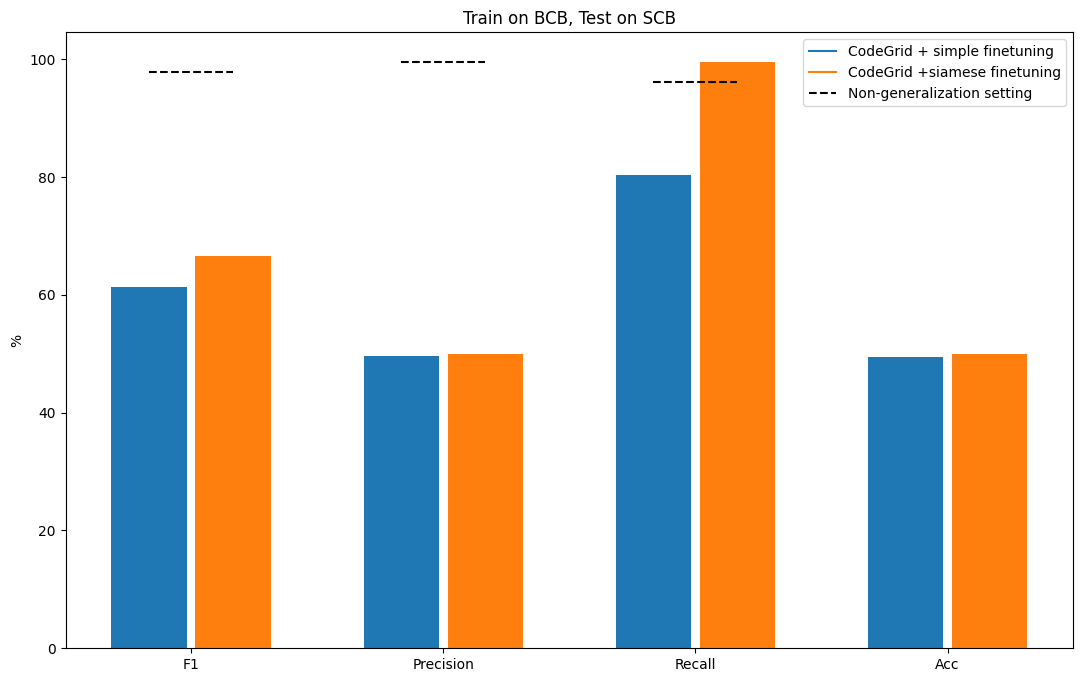

In [291]:
draw_barplot(f1, acc, p, r, model, colors, non_gen, title='Train on BCB, Test on SCB')

$F_1 = 2*\frac{P  R}{P+R}$

### SCB --> BCB

In [287]:
# ### CodeBERT
# model = 'CodeBERT'
# non_gen = codebert_non_gen_setting
# f1  = [62.9, 67.9]
# acc = [51.7, 53.9]
# p   = [82.0, 97.6]
# r   = [51.1, 52.1]

# ### ASTNN
# model = 'ASTNN'
# non_gen = astnn_non_gen_setting
# f1  = [42.4, 68.2]
# acc = [52.1, 58.3]
# p   = [53.2, 55.1]
# r   = [35.3, 89.6]

# ### CodeGrid
# model = 'CodeGrid'
# non_gen = codegrid_non_gen_setting
# f1  = [53.1, 65.3]
# acc = [49.3, 59.5]
# p   = [49.4, 57.1]
# r   = [57.3, 76.2]

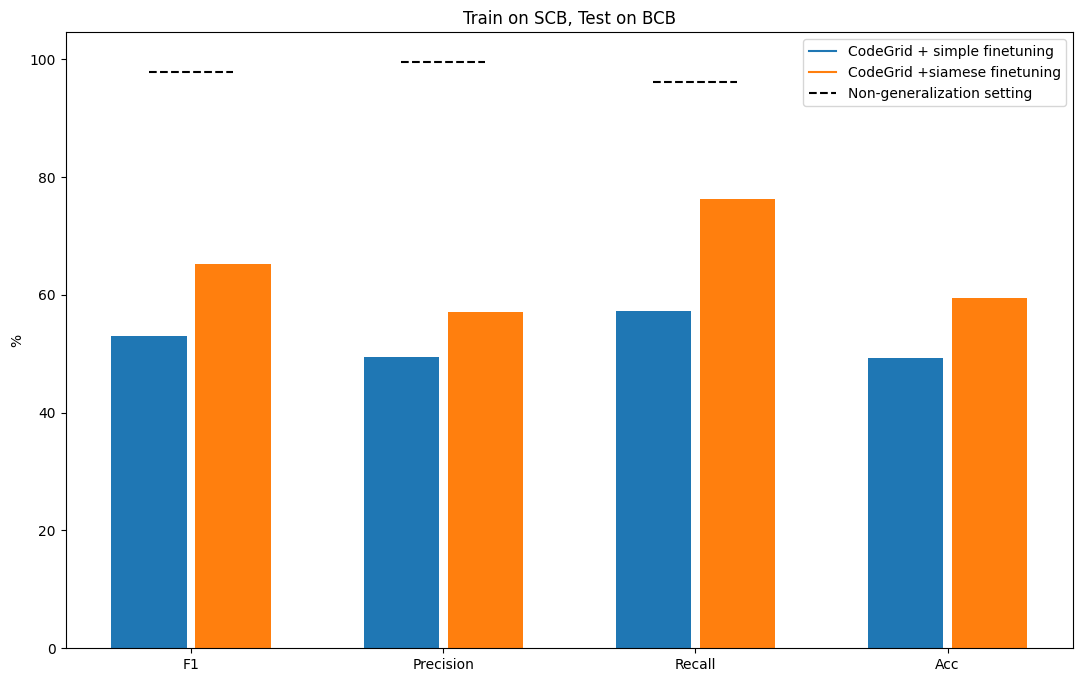

In [288]:
draw_barplot(f1, acc, p, r, model, colors, non_gen, title='Train on SCB, Test on BCB')

### 